# Assignment n°2 - System Benchmarking

## Research method SS23

### Group n°8: 
    -   Grégoire de Lambertye 
    -   add names

## Network creation

### Small netwok

This type of network is characterized by a high degree of clustering and a small average path length between nodes. (E.g., Facebook and Twitter). A virus that spreads quickly through one densely connected group of nodes could have a significant impact on the entire network.

We use Watts-Strogatz method togenerate small-world networks

In [180]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd

# set seed
rd.seed(123)

In [181]:
# Parameters
N = 250  # Number of nodes
K = 4   # Number of nearest neighbors each node is initially connected to
p = 0.2 # Probability of rewiring

In [182]:
# Generate Watts-Strogatz model
ws_model = nx.watts_strogatz_graph(N, K, p)

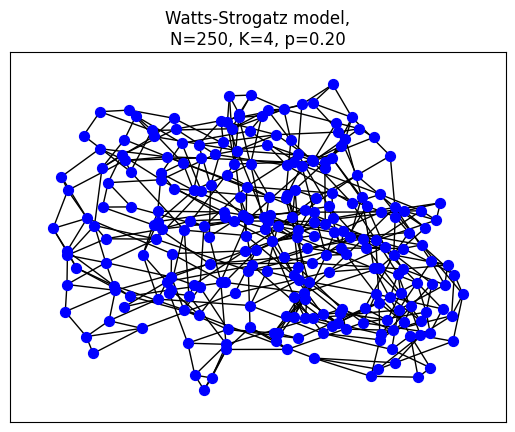

In [183]:
# Plot the graph
nx.draw_networkx(ws_model, with_labels=False, node_size=50, node_color='b')
plt.title(f"Watts-Strogatz model,\nN={N}, K={K}, p={p:.2f}")
plt.show()

### Scale-free network

This type of network is characterized by a small number of highly connected nodes and many poorly connected nodes. A virus that targets one or more of the hubs in a scale-free network could spread quickly and have a significant impact on the network.

We use Barabasi-Albert model for scale-free networks

In [184]:
# Parameters
N = 250  # Number of nodes
m = 2   # Number of edges to attach from a new node

In [185]:
# Generate scale-free network using Barabasi-Albert model
sf_model = nx.barabasi_albert_graph(N, m)

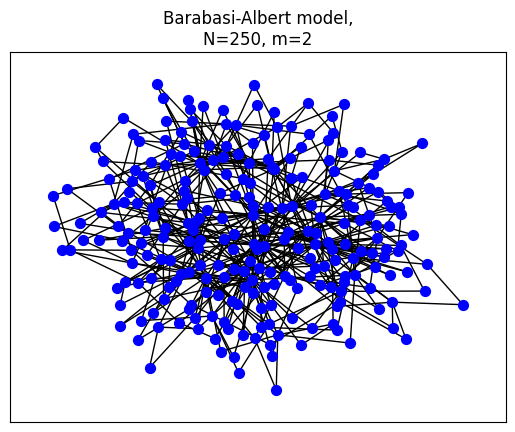

In [186]:
# Plot the graph
nx.draw_networkx(sf_model, with_labels=False, node_size=50, node_color='b')
plt.title(f"Barabasi-Albert model,\nN={N}, m={m}")
plt.show()

### Community network network

This type of network is characterized by multiple clusters of nodes that are more densely connected to each other than to nodes in other clusters. (E.g., social networks based on geographic location). A virus that spreads quickly through one or more of the tightly connected clusters could have a significant impact on those communities.

We use Lancichinetti-Fortunato-Radicchi (LFR) model for community networks.

In [187]:
# Parameters
N = 250
tau1 = 2.5
tau2 = 1.7
mu = 0.05
average_degree = 5
min_community = 50

In [188]:
# Generate LFR community network
lfr_network = nx.LFR_benchmark_graph(N, tau1, tau2, mu, seed=10, average_degree=average_degree, min_community=min_community)

In [189]:
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.08
G = nx.LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=4, min_community=20, seed=10
)

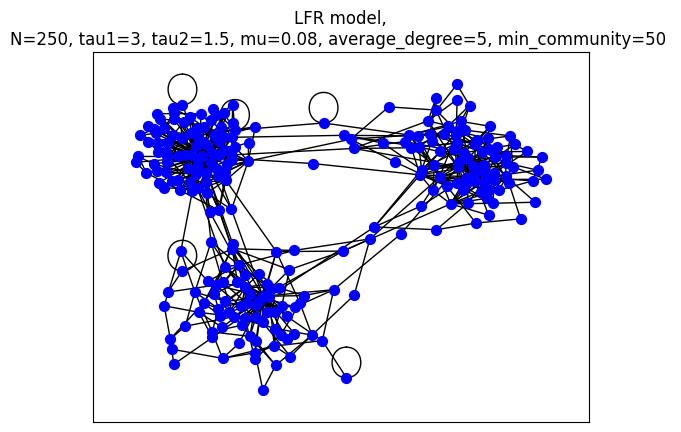

In [190]:
# Plot the graph
nx.draw_networkx(lfr_network, with_labels=False, node_size=50, node_color='b')
plt.title(f"LFR model,\nN={N}, tau1={tau1}, tau2={tau2}, mu={mu}, average_degree={average_degree}, min_community={min_community} ")
plt.show()

### Random network

This type of network is characterized by nodes that are connected randomly, with no preferential attachment to other nodes. We will use this as a baseline for the comparison.

In [191]:
# Parameters
N = 250  # Number of nodes
p = 0.025  # Probability of edge creation

In [192]:
# Generate random network
random_network = nx.gnp_random_graph(N, p)

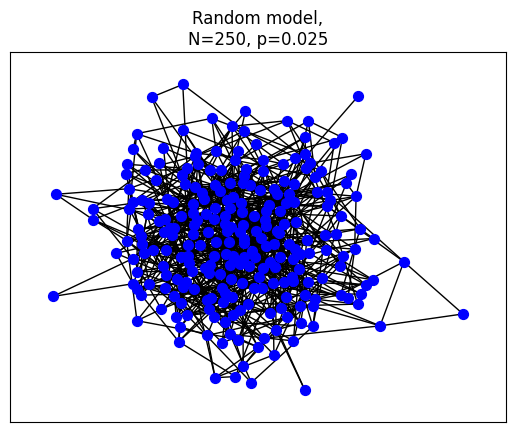

In [193]:
# Plot the graph
nx.draw_networkx(random_network, with_labels=False, node_size=50, node_color='b')
plt.title(f"Random model,\nN={N}, p={p}")
plt.show()

In [194]:
# create a list of all the models
models = [ws_model, sf_model, lfr_network, random_network]

## Virus

In [206]:
# parameters
p_infection = 0.2  # Probability of infection per tick
model_names = ["ws_model", "sf_model", "lfr_network", "random_network"] # Names of the models
ticks = 100  # Number of ticks to run the simulation for

In [205]:
for network in models:
    infected_node = rd.choice(list(network.nodes()))
    infected_nodes = {infected_node}

    # Set the number of ticks and initialize the clock
    clock = 0

    # Start the simulation
    while clock < ticks:        
        new_infections = set()
        
        # Iterate over each infected node
        for node in infected_nodes:
            # Infect neighboring nodes with the given probability
            neighbors = network.neighbors(node)
            for neighbor in neighbors:
                if neighbor not in infected_nodes and rd.random() < p_infection:
                    new_infections.add(neighbor)
        
        # Add newly infected nodes to the infected set
        infected_nodes.update(new_infections)
        
        clock += 1

    count = 0
    
    print("Network:", model_names[count])
    print("Network statistic:", network)
    print("Infected nodes:", len(infected_nodes), "\n")
    count += 1

Network: ws_model
Network statistic: Graph with 250 nodes and 500 edges
Infected nodes: 23


Network: ws_model
Network statistic: Graph with 250 nodes and 496 edges
Infected nodes: 218


Network: ws_model
Network statistic: Graph with 250 nodes and 659 edges
Infected nodes: 148


Network: ws_model
Network statistic: Graph with 250 nodes and 823 edges
Infected nodes: 245


